# Import Libraries and Load Datasets

In [1]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
annotations = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
images = "../input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("../input/face-mask-detection-dataset/submission.csv")

# Load SSD Face Detector

In [2]:
cvNet = cv2.dnn.readNetFromCaffe('../input/caffe-face-detector-opencv-pretrained-model/architecture.txt','../input/caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

# Util Functions

1. getJSON Function fetches the json file.

In [3]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

2. Gamma correction is a nonlinear operation used to encode and decode luminance values in video or still image systems. It is used to instill some light in the image. If gamma < 1, image will shift towards darker end of the spectrum and when gamma > 1, there will be more light in the image.

In [4]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

# Data Preprocessing

When we're lookong into training JSON data, we can find out the next:
* Anntoations fiels holds data about faces as a coorsinates of rectagular area
* Also each annotation holds name of the class, We;re interested in **"face_with_mask"** and **"face_no_mask"** classes.

Lets' see sample data from training set.

In [5]:
files = []
for i in os.listdir(annotations):
    files.append(getJSON(os.path.join(annotations,i)))
files[0]

{'FileName': '3758.png',
 'NumOfAnno': 2,
 'Annotations': [{'isProtected': False,
   'ID': 217843115901993120,
   'BoundingBox': [112, 4, 455, 441],
   'classname': 'face_with_mask',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 12530598208497002,
   'BoundingBox': [113, 237, 345, 440],
   'classname': 'mask_colorful',
   'Confidence': 1,
   'Attributes': {}}]}


Now we'll arrange the training dataset.

In [6]:
df = pd.read_csv("../input/face-mask-detection-dataset/train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


* We'll use **mask label** and **non_mask label** to extract bounding box data from json files.
* We'll store faces from any particular image in the **train** list along with its label for the training process.

In [7]:
train = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(annotations,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(images,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            train.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(images,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            train.append([img,labels["without mask"]])
random.shuffle(train)  
len(train)

5749

Now, we'll prepare test data and split data and labels.

In [8]:
X = []
Y = []
for features,label in train:
    X.append(features)
    Y.append(label)
    
X[0].shape

(124, 124, 3)

In [9]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)

Y = np.array(Y)
print(np.unique(Y))
Y.shape

[0 1]


(5749,)

# Model training

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

Model summary:

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 128)       0         
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                        

Now we can compile the model:

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

We will split training data set to traqin and validation:

In [13]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

Now, we'll generate tensor make data using ImageDataGenerator:

In [14]:
tensordata = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
tensordata.fit(xtrain)

And we can fit our model:

In [15]:
history = model.fit_generator(tensordata.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/50


2023-03-24 06:31:06.831677: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


143/143 [==============================] - 41s 174ms/step - loss: 0.4480 - accuracy: 0.8327 - val_loss: 0.2432 - val_accuracy: 0.9026
Epoch 2/50
143/143 [==============================] - 23s 158ms/step - loss: 0.2915 - accuracy: 0.8820 - val_loss: 0.2227 - val_accuracy: 0.9130
Epoch 3/50
143/143 [==============================] - 22s 152ms/step - loss: 0.2789 - accuracy: 0.8811 - val_loss: 0.2671 - val_accuracy: 0.9096
Epoch 4/50
143/143 [==============================] - 23s 159ms/step - loss: 0.2592 - accuracy: 0.8890 - val_loss: 0.2097 - val_accuracy: 0.9217
Epoch 5/50
143/143 [==============================] - 22s 152ms/step - loss: 0.2465 - accuracy: 0.9017 - val_loss: 0.2331 - val_accuracy: 0.9035
Epoch 6/50
143/143 [==============================] - 22s 154ms/step - loss: 0.2398 - accuracy: 0.9026 - val_loss: 0.2150 - val_accuracy: 0.9339
Epoch 7/50
143/143 [==============================] - 22s 156ms/step - loss: 0.2391 - accuracy: 0.9083 - val_loss: 0.1969 - val_accuracy: 0.9

Also we can visualoze trainig vs validation results.

Accuracy:

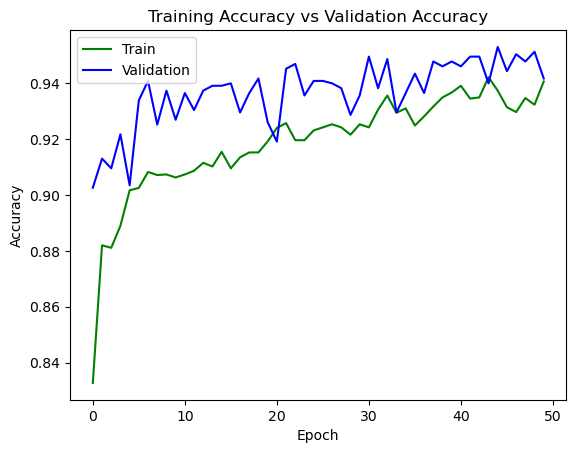

In [16]:
plt.plot(history.history['accuracy'],'g')
plt.plot(history.history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Loss:

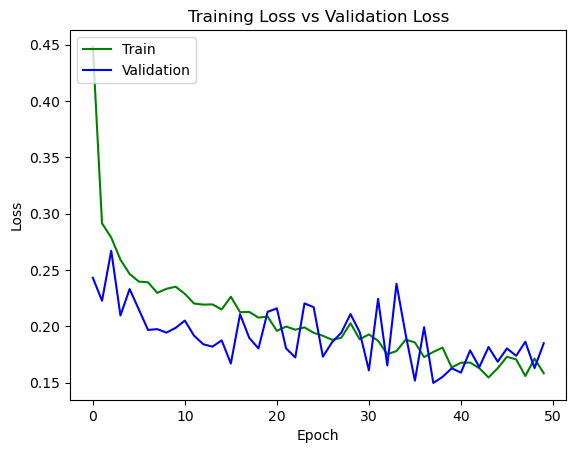

In [17]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Testing our model